In [1]:
# Imports:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.metrics import mean_squared_error
import plotly.express as px
from scipy import stats
from scipy.stats import norm
from dieboldmariano import dm_test
from dm_config import *

import torch
import pickle
import random

In [2]:
#set seed for reproducibility
random_state = 0
np.random.seed(random_state)

In [3]:
with open(bidirectional_results_path, 'rb') as f:
    bidirectional_preds = pickle.load(f)

with open(hgru_results_path, 'rb') as f:
    hgru_preds = pickle.load(f)

with open(baseline_results_path, 'rb') as f:
    baseline_preds = pickle.load(f)

with open(actual_path, 'rb') as f:
    raw_dataset_dict = pickle.load(f)

In [4]:
#sanity checks:
print(f'bidirectional: {bidirectional_preds["All-items"].shape}')
print(f'hgru: {hgru_preds["All-items"].shape}')
print(f'basic: {baseline_preds["All-items"].shape}')

bidirectional: torch.Size([1, 28])
hgru: torch.Size([1, 28])
basic: torch.Size([1, 28])


In [5]:
def create_test_dataframe(raw_dataset_dict: dict):
    test_dict = {}
    for key in raw_dataset_dict.keys():
        df = raw_dataset_dict[key][['Category', 'Date', 'Year', 'Inflation t+1']]
        df.dropna(inplace=True)
        df.rename(columns={'Inflation t+1': 'Actual'}, inplace=True)
        target_df = df[df['Year'] > Year]
        test_dict[key] = target_df
    return test_dict

test_dict = create_test_dataframe(raw_dataset_dict)


/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_1159/483307922.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_1159/483307922.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Inflation t+1': 'Actual'}, inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_1159/483307922.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [6]:
def get_df_with_predictions(bi_direc_preds: dict, hrnn_preds: dict, baseline_preds: dict, dict_of_categories_df:dict) -> dict:
    all_data_dict = {}
    for key in list(bi_direc_preds.keys()):
        bi_directional_predictions = bi_direc_preds[key]
        hrnn_predictions = hrnn_preds[key]
        baseline_predictions = baseline_preds[key]
        
        bi_directional_pred_df =  pd.DataFrame(bi_directional_predictions.flatten().detach().numpy())
        bi_directional_pred_df.rename(columns = {0: 'Bi-Directional Prediction'}, inplace=True)
        
        hrnn_pred_df =  pd.DataFrame(hrnn_predictions.flatten().detach().numpy())
        hrnn_pred_df.rename(columns = {0: 'HRNN Prediction'}, inplace=True)

        baseline_pred_df =  pd.DataFrame(baseline_predictions.flatten().detach().numpy())
        baseline_pred_df.rename(columns = {0: 'Baseline Prediction'}, inplace=True)

        dict_of_categories_df[key] = dict_of_categories_df[key].reset_index(drop=True)
        df1 = pd.concat([dict_of_categories_df[key], bi_directional_pred_df], axis=1)
        df2 = pd.concat([df1, hrnn_pred_df], axis=1)
        df3 = pd.concat([df2, baseline_pred_df], axis=1)

        all_data_dict[key] = df3

    return all_data_dict

all_data_test_dict = get_df_with_predictions(bidirectional_preds, hgru_preds, baseline_preds , test_dict)

# General:

In [7]:
def diebold_mariano_test_better_categories(all_data_test_dict):
    better_cats_pval = []
    all_pvals = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        dm_statistic = dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=True)
        
        if np.mean(squared_errors_bi_directional) < np.mean(squared_errors_hrnn):
            better_cats_pval.append(dm_statistic[1])
        
        all_pvals.append(dm_statistic[1])

    print(f'Number of Better Categories: {len(better_cats_pval)}')
    print(f'Total Categories: {len(list(all_data_test_dict.keys()))}')
    print(f"Better Category %: {round(100*len(better_cats_pval)/len(list(all_data_test_dict.keys())),4)}")
    print(f'Median P-value Better Categories: {np.median(better_cats_pval)}')
    print(f'Median P-value All Categories: {np.median(all_pvals)}')
        
    return better_cats_pval, all_pvals

In [8]:
res = diebold_mariano_test_better_categories(all_data_test_dict)

Number of Better Categories: 42
Total Categories: 52
Better Category %: 80.7692
Median P-value Better Categories: 0.17071446116015898
Median P-value All Categories: 0.22595372833830088


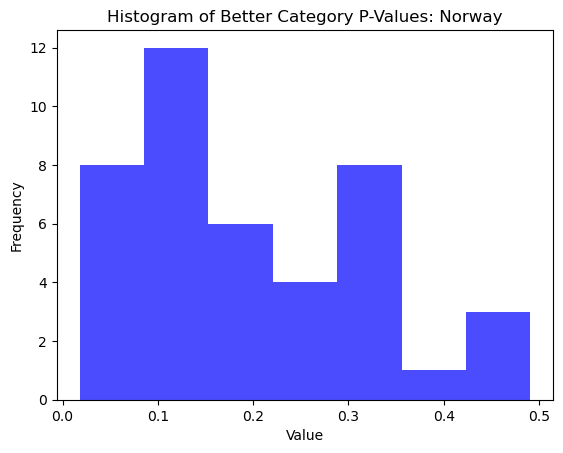

In [9]:
# Creating the histogram
plt.hist(res[0], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of Better Category P-Values: Norway')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


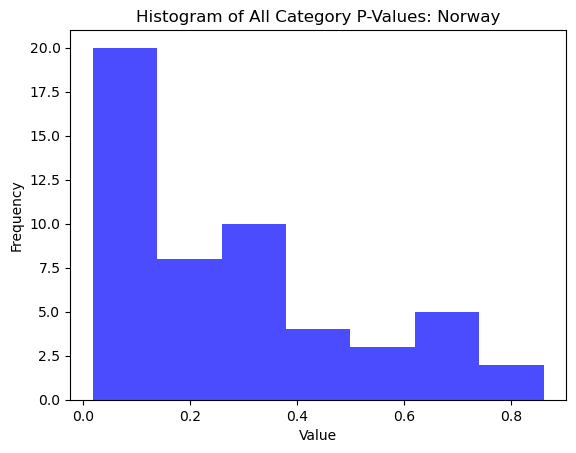

In [10]:

# Creating the histogram
plt.hist(res[1], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of All Category P-Values: Norway')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


# P-Value < 0.1:

In [11]:
def diebold_mariano_test_better_categories2(all_data_test_dict):
    better_cats_pval = []
    all_pvals = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        dm_statistic = dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=True)
        
        if (np.mean(squared_errors_bi_directional) < np.mean(squared_errors_hrnn)) and (dm_statistic[1]<0.1):
            better_cats_pval.append(dm_statistic[1])
        
        all_pvals.append(dm_statistic[1])

    print(f'Number of Better Categories: {len(better_cats_pval)}')
    print(f'Total Categories: {len(list(all_data_test_dict.keys()))}')
    print(f"Better Category %: {round(100*len(better_cats_pval)/len(list(all_data_test_dict.keys())),4)}")
    print(f'Median P-value Better Categories: {np.median(better_cats_pval)}')
    print(f'Median P-value All Categories: {np.median(all_pvals)}')
        
    return better_cats_pval, all_pvals

In [12]:
res2 = diebold_mariano_test_better_categories2(all_data_test_dict)

Number of Better Categories: 15
Total Categories: 52
Better Category %: 28.8462
Median P-value Better Categories: 0.07569707609207116
Median P-value All Categories: 0.22595372833830088


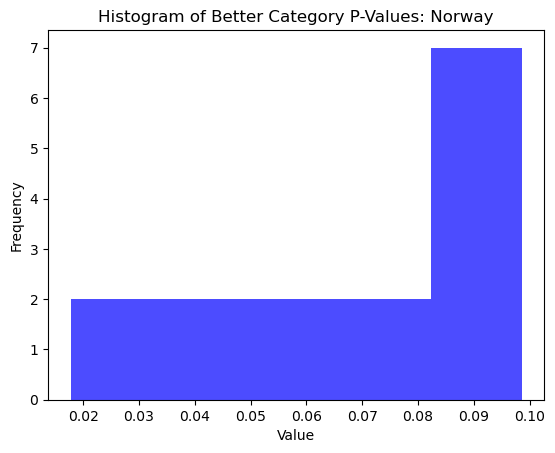

In [13]:
# Creating the histogram
plt.hist(res2[0], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of Better Category P-Values: Norway')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# P-Value < 0.05:

In [14]:
def diebold_mariano_test_better_categories3(all_data_test_dict):
    better_cats_pval = []
    all_pvals = []
    for category in list(all_data_test_dict.keys()):
        df = all_data_test_dict[category]
        forecast_bi_directional = df['Bi-Directional Prediction']
        forecast_hrnn = df['HRNN Prediction']
        actual_values = df['Actual']

        squared_errors_bi_directional = (forecast_bi_directional - actual_values)**2
        squared_errors_hrnn = (forecast_hrnn - actual_values)**2

        dm_statistic = dm_test(actual_values, forecast_bi_directional, forecast_hrnn, one_sided=True)
        
        if (np.mean(squared_errors_bi_directional) < np.mean(squared_errors_hrnn)) and (dm_statistic[1]<0.05):
            better_cats_pval.append(dm_statistic[1])
        
        all_pvals.append(dm_statistic[1])

    print(f'Number of Better Categories: {len(better_cats_pval)}')
    print(f'Total Categories: {len(list(all_data_test_dict.keys()))}')
    print(f"Better Category %: {round(100*len(better_cats_pval)/len(list(all_data_test_dict.keys())),4)}")
    print(f'Median P-value Better Categories: {np.median(better_cats_pval)}')
    print(f'Median P-value All Categories: {np.median(all_pvals)}')
        
    return better_cats_pval, all_pvals

In [15]:
res3 = diebold_mariano_test_better_categories3(all_data_test_dict)

Number of Better Categories: 4
Total Categories: 52
Better Category %: 7.6923
Median P-value Better Categories: 0.02832107495627479
Median P-value All Categories: 0.22595372833830088


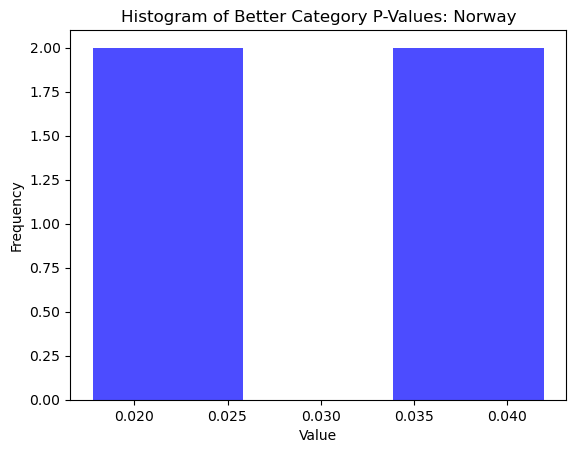

In [16]:
# Creating the histogram
plt.hist(res3[0], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram of Better Category P-Values: Norway')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()